# Project: Investigate a Dataset (Medical Appointment No Shows)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Section I: Introduction

**Selected dataset**: [No-show appointments](https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd2e9a_noshowappointments-kagglev2-may-2016/noshowappointments-kagglev2-may-2016.csv)

**Dataset Description**: This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.
- ‘ScheduledDay’ tells us on what day the patient set up their appointment.
- ‘Neighborhood’ indicates the location of the hospital.
- ‘Scholarship’ indicateswhether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
- **Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.**

We will try to find out what factors are important for us to know in order to predict if a patient will show up for their scheduled appointment or not.

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

<a id='wrangling'></a>
## Section II: Data Wrangling

### General Properties

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('No-show appointments.csv')

In [3]:
# Let's have an initial view on the data
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
# Learn the size of the dataset
df.shape

(110527, 14)

The dataset includes **14** columns and **110527** data rows.

### Missing Values Validation

In [5]:
# And another view on the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


No missing values.

### Duplicated Values Validation

In [6]:
# Check for duplicate rows 
sum(df.duplicated())

0

In [7]:
# Check for duplicate appointmentID
sum(df.AppointmentID.duplicated())

0

The cell above shows no duplicates in the **`AppointmentID`** column.

In [8]:
sum(df.PatientId.duplicated())

48228

In [9]:
df.PatientId.value_counts().head()

8.221459e+14    88
9.963767e+10    84
2.688613e+13    70
3.353478e+13    65
7.579746e+13    62
Name: PatientId, dtype: int64


**`PatientId`** column contains too many repeated values which means same patients booked more than an appointment.

### Incorrect Data Validation (Depending on the nature of each column)

In [10]:
# Check for datatypes of dataset variables
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

- **`PatientId`** data type is invalid (float not integer).
- **`ScheduledDay`** and **`AppointmentDay`** data type is invalid (string not datetime).
- Taking a look back to **`head()`** method, **`AppointmentDay`** has no hour specified (it equals to 00:00:00). We will not be able to analyze if the appointment hour has anything to do with no shows.

In [11]:
# Check some descriptive statistics
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [12]:
# Check number of negative values in `Age` column
sum(df.Age < 0)

1



There is probably a mistake with one of patient's age. Minimum value shows -1 which doesn't make sense.

In [13]:
# Overview about number of unique values
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

In [14]:
# Check values in `Handcap` column
df.Handcap.value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64


Looking at the values in the **`Handcap`** column, we see 5 values (0,1,2,3,4)

We can summarize our assessment in the following points:
- The dataset includes **14** columns and **110527** data rows.
- There is no missing values.
- **`AppointmentID`** will be considered the primary key in our analysis. There is no duplicates in this column.
- **`PatientId`** column contains too many repeated values which means same patients booked more than an appointment.
- **`PatientId`** data type is invalid (float not integer).
- **`ScheduledDay`** and **`AppointmentDay`** data type is invalid (string not datetime).
- **`AppointmentDay`** has no hour specified (it equals to 00:00:00). We will not be able to analyze if the appointment hour has anything to do with no shows.
- There is probably a mistake with one of patient's age. Minimum value shows -1 which doesn't make sense..
- Looking at the values in the **`Handcap`** column, we see 5 values (0,1,2,3,4).
- There could be interesting to know how much time passed between a visit scheduling time and the actual visit time. There is no such data column but this can be calculated from **`ScheduledDay`** and **`AppointmentDay`** columns called **`Waiting_duration`**
- Another interesting question would be how show and no-show appointments are distributed among days of week. To explore this I will calculate a column called **`Day_of_week`**.

### 3. Data Cleaning

In [15]:
# Rename Columns
df.columns = ['Patient_ID', 'Appointment_ID', 'Gender', 'Scheduled_Day',
       'Appointment_Day', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'No_show']

In [16]:
# Convert PatientID to integer 
df.Patient_ID = df.Patient_ID.astype('int64')

# Check if the PatientID is int64
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Patient_ID       110527 non-null  int64 
 1   Appointment_ID   110527 non-null  int64 
 2   Gender           110527 non-null  object
 3   Scheduled_Day    110527 non-null  object
 4   Appointment_Day  110527 non-null  object
 5   Age              110527 non-null  int64 
 6   Neighbourhood    110527 non-null  object
 7   Scholarship      110527 non-null  int64 
 8   Hypertension     110527 non-null  int64 
 9   Diabetes         110527 non-null  int64 
 10  Alcoholism       110527 non-null  int64 
 11  Handicap         110527 non-null  int64 
 12  SMS_received     110527 non-null  int64 
 13  No_show          110527 non-null  object
dtypes: int64(9), object(5)
memory usage: 11.8+ MB


In [17]:
# Convert AppointmentDay and ScheduledDay from String to DateTime format, and 
# create 2 columns for:'Scheduled_Date' and the 'Appointment_Date'. 
# Note: Since the Appointment times were set to 00:00:00 in all the appointments, 
# our analysis won't include the appointment time.

# 'Appointment_Date'
df['Appointment_Date'] = pd.to_datetime(df.Appointment_Day).dt.date
# 'Day_of_Week'
df['Day_of_Week'] = pd.to_datetime(df.Appointment_Day).dt.day_name()
df.drop('Appointment_Day',axis=1, inplace = True)
# 'Scheduled_Date'
df['Scheduled_Date'] = pd.to_datetime(df.Scheduled_Day).dt.date
df.drop('Scheduled_Day',axis=1, inplace = True)

In [18]:
# Create a new column to show the 'Waiting_Duration' (in days) between the 'Scheduled_Date' and 'Appointment_Date' 
df['Waiting_Duration'] = df.Appointment_Date - df.Scheduled_Date

In [19]:
df.Waiting_Duration

0         0 days
1         0 days
2         0 days
3         0 days
4         0 days
           ...  
110522   35 days
110523   35 days
110524   41 days
110525   41 days
110526   41 days
Name: Waiting_Duration, Length: 110527, dtype: timedelta64[ns]

In [20]:
# Check number of negative values in `Waiting_Duration` column
df[df.Waiting_Duration < '0 days']

,Patient_ID,Appointment_ID,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,Appointment_Date,Day_of_Week,Scheduled_Date,Waiting_Duration
27033,7839272661752,5679978,M,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,2016-05-09,Monday,2016-05-10,-1 days
55226,7896293967868,5715660,F,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,2016-05-17,Tuesday,2016-05-18,-1 days
64175,24252258389979,5664962,F,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,2016-05-04,Wednesday,2016-05-05,-1 days
71533,998231581612122,5686628,F,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,2016-05-05,Thursday,2016-05-11,-6 days
72362,3787481966821,5655637,M,7,TABUAZEIRO,0,0,0,0,0,0,Yes,2016-05-03,Tuesday,2016-05-04,-1 days


There are 5 appointments where the appointment was booked (recorded) after the actual appointment; Also, we checked the NoShow column and noticed that none of the patients who booked these appointment did show up (NoShow = Yes).

In [21]:
# Exclude the 5 records with the negative waiting duration, the new dataset size is 110527 - 5 = 110522
df = df[df.Appointment_Date >= df.Scheduled_Date]
df.shape

(110522, 16)

In [22]:
# Exclude the record with the negative Age value

df = df[df.Age != -1]
df.shape

(110521, 16)

In [23]:
# Two useful masks to be used in further analysis
NoShow = df.No_show == 'Yes'
Show = df.No_show == 'No'

In [24]:
df.head()

,Patient_ID,Appointment_ID,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,Appointment_Date,Day_of_Week,Scheduled_Date,Waiting_Duration
0,29872499824296,5642903,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29,Friday,2016-04-29,0 days
1,558997776694438,5642503,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29,Friday,2016-04-29,0 days
2,4262962299951,5642549,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29,Friday,2016-04-29,0 days
3,867951213174,5642828,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29,Friday,2016-04-29,0 days
4,8841186448183,5642494,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29,Friday,2016-04-29,0 days


<a id='eda'></a>
## Exploratory Data Analysis

### Questions
1. What is the overall appointment show-up vs. no show-up rate?
2. What factors are important to know in order to predict if a patient will show up for their scheduled appointment?
3. Are there more No-Shows on some days of the week?
4. Do activities of scheduling office (sending SMS, enrollment in Brasilian welfare) affect show rate?
5. Is Neighbourhood associated with lowered incidences of No Shows?

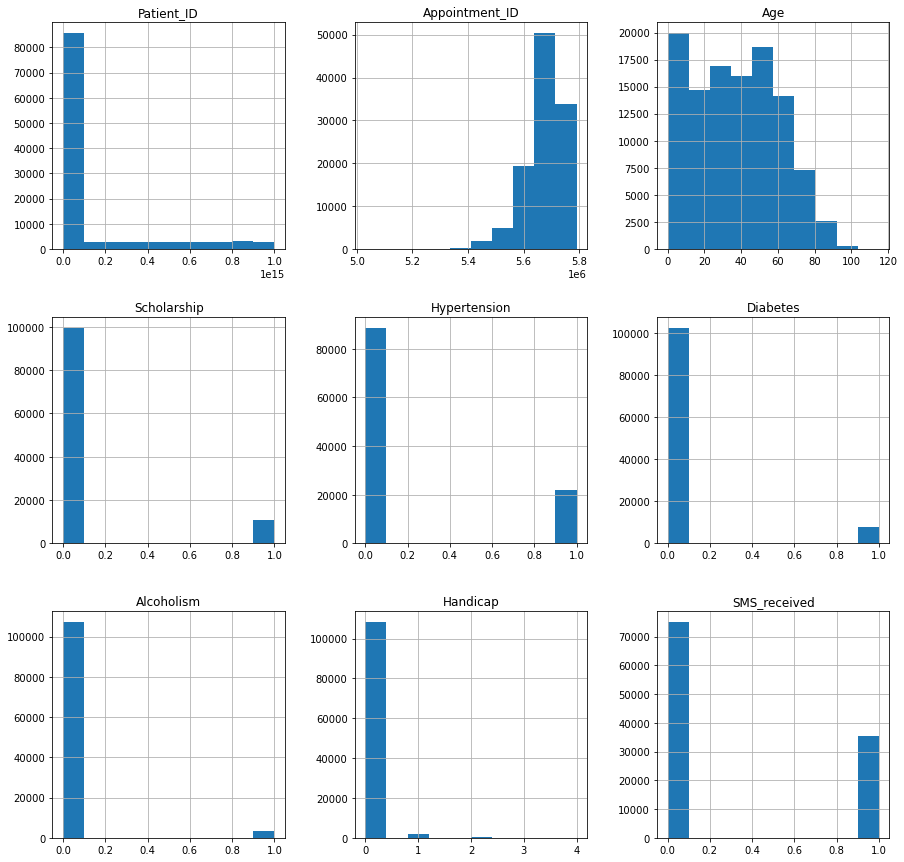

In [25]:
# First, let's take a general look on the whole dataset
df.hist(figsize= (15,15));

- The proportion of appointments where patients are from the age group (0 -10) is largest among the other age groups.
- Number of patients who recieved SMS is half the number who did not.

In [26]:
df.Waiting_Duration.value_counts()

0 days      38562
2 days       6725
4 days       5290
1 days       5213
7 days       4906
            ...  
82 days         1
126 days        1
139 days        1
101 days        1
132 days        1
Name: Waiting_Duration, Length: 129, dtype: int64

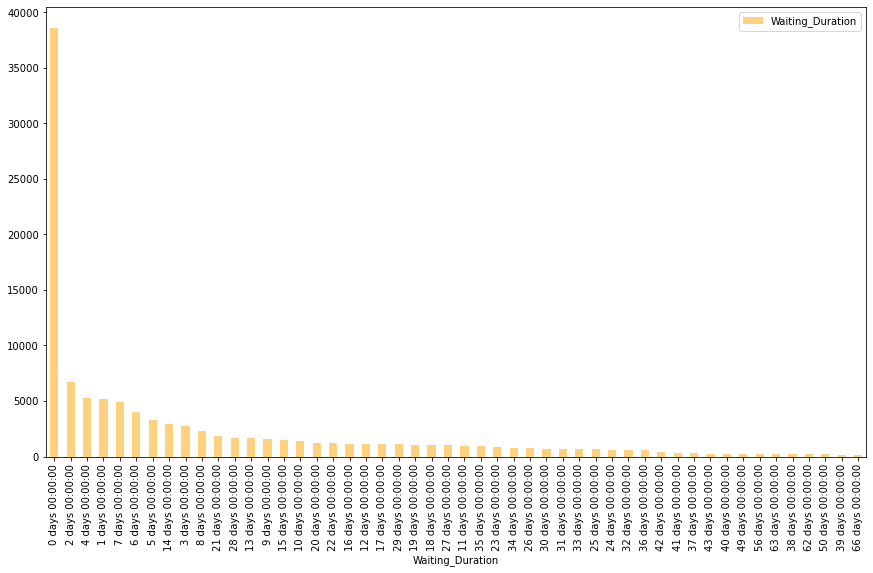

In [27]:
plt.figure(figsize=[14.7, 8.27])
df.Waiting_Duration.value_counts().head(50).plot(kind='bar', color= 'orange',alpha=0.5);
plt.legend()
plt.xlabel('Waiting_Duration');

- Almost 39 thousands of patients scheduled their visit in the same day.

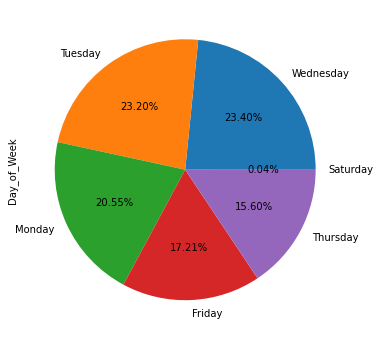

In [28]:
df.Day_of_Week.value_counts().plot.pie(figsize=(6,6), autopct='%.2f%%')
plt.show()

- Tuesday and Wednesday have higher appointments in the week while Saturday has the least.
- No appointments in Sunday.

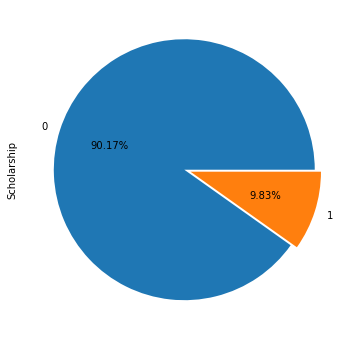

In [29]:
df.Scholarship.value_counts().plot.pie(figsize=(6,6), autopct='%.2f%%', explode=(0, .05))
plt.show()

- **9.83**% are enrolled in brasillian welfare program.

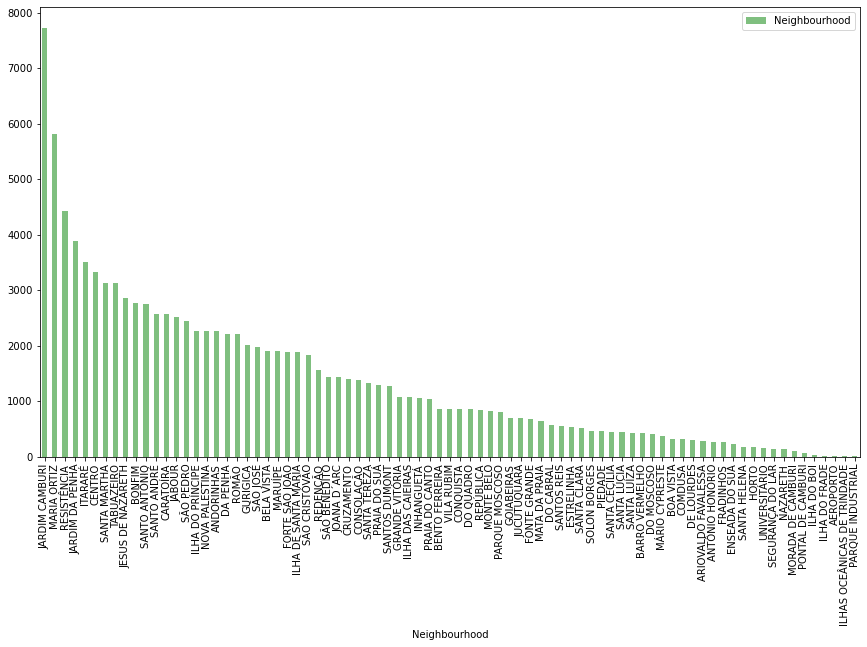

In [30]:
plt.figure(figsize=[14.7, 8.27])
df.Neighbourhood.value_counts().plot(kind='bar', color= 'green',alpha=0.5);
plt.legend()
plt.xlabel('Neighbourhood');

In [31]:
df.Neighbourhood.value_counts()

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4430
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: Neighbourhood, Length: 81, dtype: int64

- Most of patients(7717) scheduled their visit from Jardim Csmburi.

In [32]:
def create_histogram(column_name = ""):
    plt.figure(figsize=[14.7, 8.27])
    df[column_name][Show].hist(alpha=0.5, label= 'Show');
    df[column_name][NoShow].hist(alpha=0.5, label= 'NoShow');
    plt.legend()
    plt.title('Comparison between who showed to those who didn\'t show according to {}'.format(column_name))
    plt.xlabel('{}'.format(column_name));

### Research Question 1: what is the overall appointment show-up vs. no show-up rate?

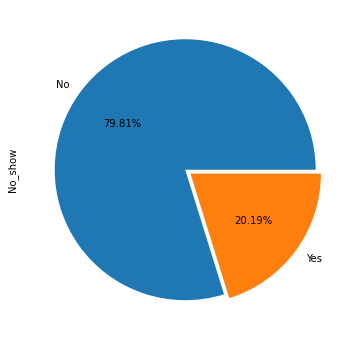

In [33]:
df.No_show.value_counts().plot.pie(figsize=(6,6), autopct='%.2f%%', explode=(0, .05))
plt.show()

- 20.19% of appointments were missed.
- So, now I will search for factors with much bigger difference than 20% in no-shows rates, these factors are with great significance in our research.

### Research Question 2: What factors are important to know in order to predict if a patient will show up for their scheduled appointment?

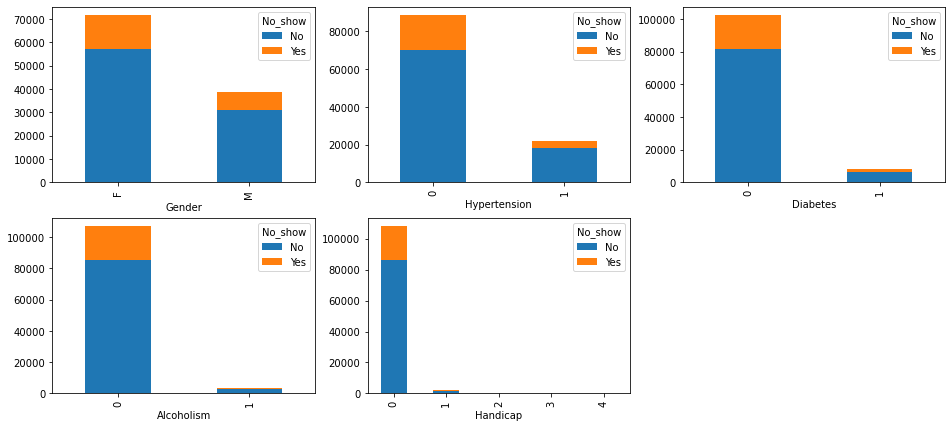

In [34]:
# First, let's look at categorical variables
categorical_vars = ['Gender', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap']

fig = plt.figure(figsize=(16, 11))
for i, var in enumerate(categorical_vars):
    ax = fig.add_subplot(3, 3, i+1)
    df.groupby([var, 'No_show'])[var].count().unstack('No_show').plot(ax=ax, kind='bar', stacked=True)
# Other categorical variables will be discussed individually later

- The ratio of show / no-show for different categories look very similar. There is no significant of any of these variables having bigger impact than others.
- The plot confirms no-show rate close to 20% for almost all.

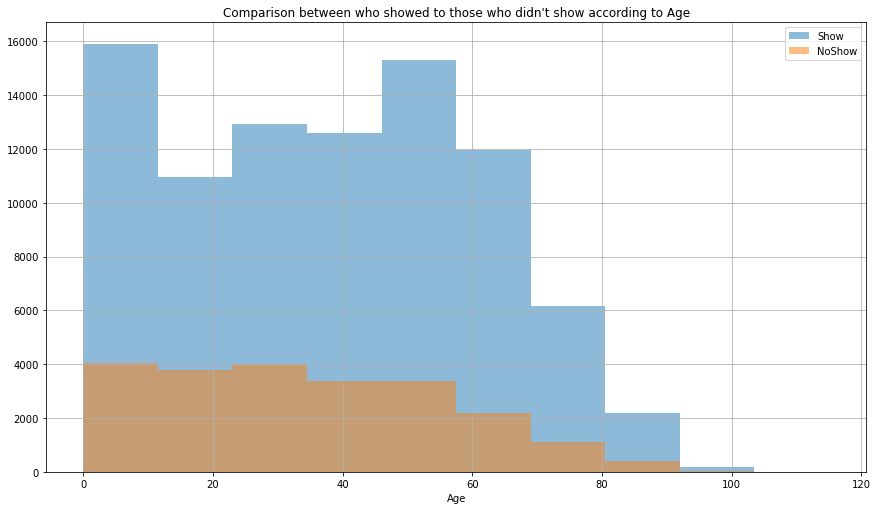

In [35]:
# Let's now look closer to numerical variables
# Age:
create_histogram(column_name = "Age")

- Patients between 10-25 years with incredibly higher no-show rates(about 36%) then people around 25-35(about 30%). 
- Between 60-80 years old, patients are with show up rate the most, the rate of no-shows seems to be slightly lower(16%)

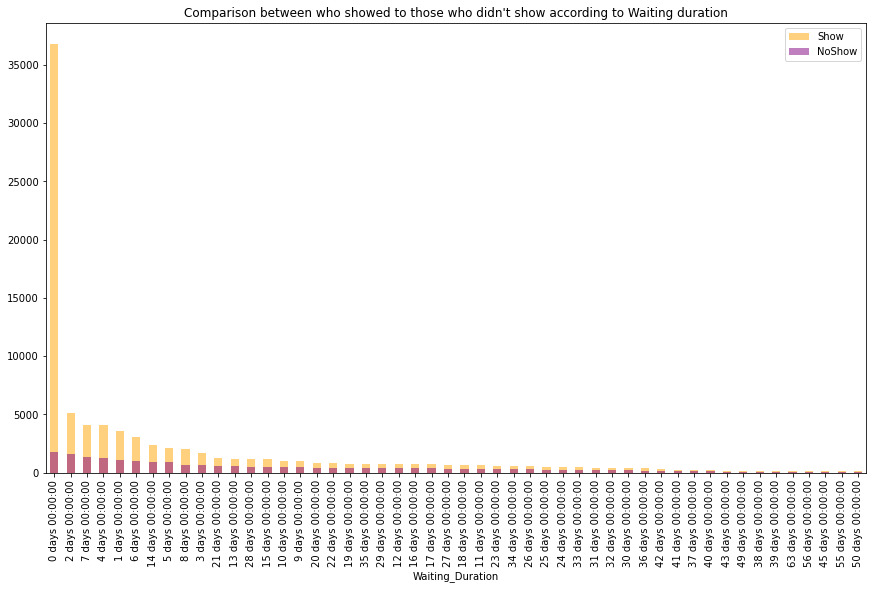

In [36]:
plt.figure(figsize=[14.7, 8.27])
df.Waiting_Duration[Show].value_counts().head(50).plot(kind='bar', color= 'orange',alpha=0.5, label= 'Show');
df.Waiting_Duration[NoShow].value_counts().head(50).plot(kind='bar', color= 'purple',alpha=0.5, label= 'NoShow');
plt.legend()
plt.title('Comparison between who showed to those who didn\'t show according to Waiting duration')
plt.xlabel('Waiting_Duration');

- Shorter waiting duration, the more patients show up.
- But patiens scheduling appointments for the same day are clearly with the least no-shows rate (about 6%).

### Research Question 3: Are there more No-Shows on some days of the week?


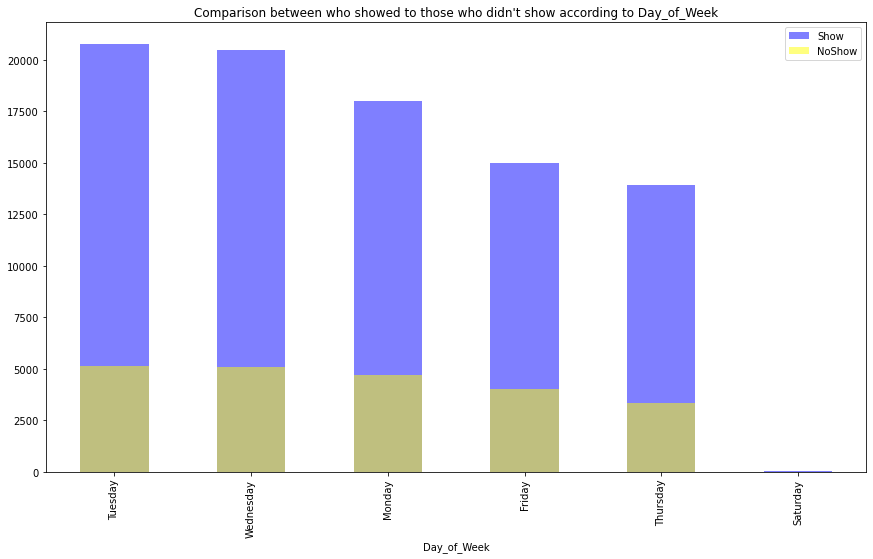

In [37]:
# Compare who showed to those who didn't show according to Day_of_Week
plt.figure(figsize=[14.7, 8.27])
df.Day_of_Week[Show].value_counts().plot(kind='bar', color= 'blue',alpha=0.5, label= 'Show');
df.Day_of_Week[NoShow].value_counts().plot(kind='bar', color= 'yellow',alpha=0.5, label= 'NoShow');
plt.legend()
plt.title('Comparison between who showed to those who didn\'t show according to Day_of_Week')
plt.xlabel('Day_of_Week');

- There are higher incidences of no-shows on Thursdays and Fridays (more than30%)

### Research Question 4:  Do activities of scheduling office (sending SMS, enrollment in Brasilian welfare) affect show rate?

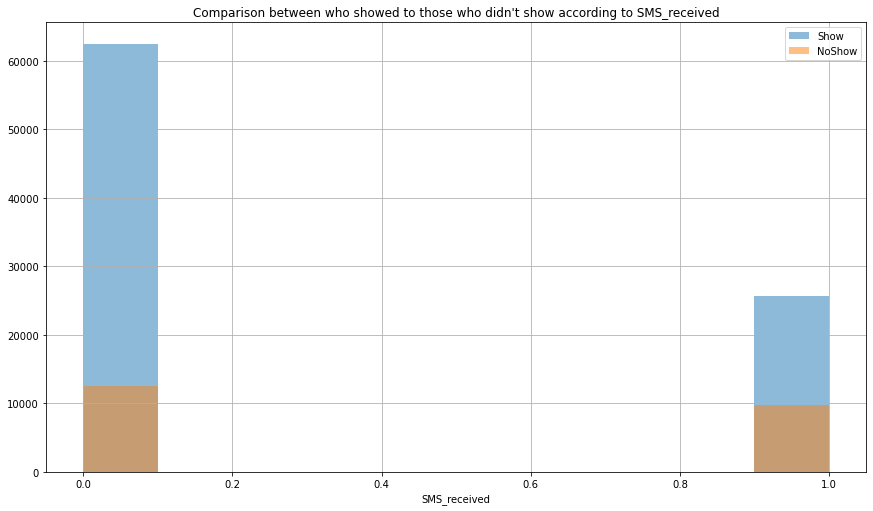

In [38]:
# SMS_received:
create_histogram(column_name = 'SMS_received')

- Suprisingly, the percentage of no-shows is much higher when SMS messages were received(about 40%).

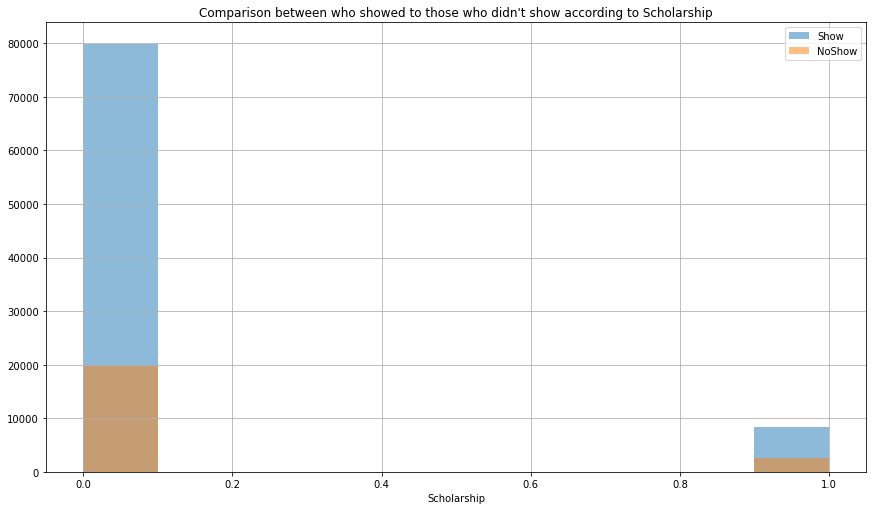

In [39]:
# Scholarship:
create_histogram(column_name = "Scholarship")

- Enrollment in Brasilian welfare program is not really significant.

### Research Question 5: Is Neighbourhood associated with lowered incidences of No Shows?

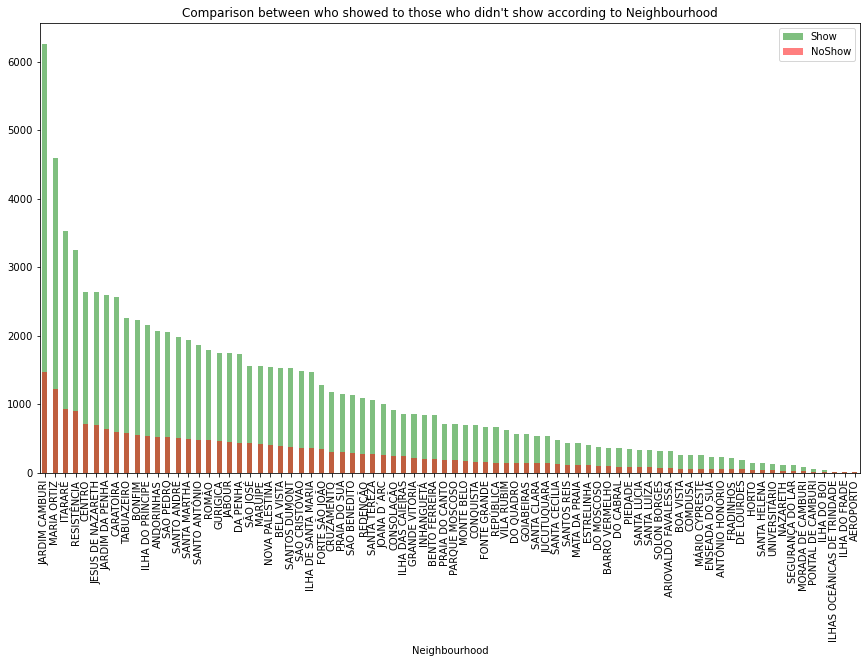

In [40]:
# Compare who showed to those who didn't show according to Neighbourhood
plt.figure(figsize=[14.7, 8.27])
df.Neighbourhood[Show].value_counts().plot(kind='bar', color= 'green',alpha=0.5, label= 'Show');
df.Neighbourhood[NoShow].value_counts().plot(kind='bar', color= 'red',alpha=0.5, label= 'NoShow');
plt.legend()
plt.title('Comparison between who showed to those who didn\'t show according to Neighbourhood')
plt.xlabel('Neighbourhood');

- This plot may show many neighbourhoods with high no-show rates, but it doesn't matter because these neighbourhoods with less number of appointments with high standard errors.
- So, neighbourhood is not really significant.

<a id='conclusions'></a>
## Conclusions


-I overviewed our dataset and clean a few problems like renaming some columns, removing wrong data, adding new columns as waiting duration and day of week based on existing columns.

-I also investigated most of the independent variables in the dataset and made a few notes comparing them to the dependent one (No_Show).
-I asked some questions as exploratory analysis and started to find out their answers using different visualisations. And I found out:
 > No-shows rate:
 - 20.19% of appointments were missed.
 
 > Age: hardly significant
 - Patients between 10-25 years with incredibly higher no-show rates(about 36%) then people around 25-35(about 30%), otherwise between 60-80 years old, patients are with show up rate the most, the rate of no-shows seems to be slightly lower(about 16%). 
 - In the end, I see that age is hardly significant because every age group differs in their own suspected diseases as teenagers and young adults with more probability of curably simple diseases otherwise elderly people, with often intuitively diseases for old ages as diabetes or hypertension controlled of medicines and not curable, make them commit their follow-ups.
 
 > Waiting duration: significant
 - Shorter the waiting duration, the more patients show up.
 - But patients scheduling appointments for the same day are clearly with the least no-shows rate (about 6%).
 
 > Day of the week: significant
 - There are higher incidences of no-shows on Thursdays and Fridays (more than30%)
 
 > SMS: oddly significant !!
 - The percentage of no-shows is Surprisingly much higher when SMS messages were received(about 40%).
 
 > Enrollment in Brasilian welfare program: not significant
 
 > Neighbourhood: not significant
 - Visualisations may show many neighbourhoods with high no-show rates, but it doesn't matter because of these neighbourhoods with relatively fewer appointments with high standard errors.
 
-limitations:
- **Patient_Id** column contains **48228** repeated values, more than 40% of whole appointments, which means too many false insights and correlations in further exploratory analysis.
- Difficulty to detect a direct correlation between and many variables as gender, hypertension, diabetes, alcoholism and handicaps.
- The data should be investigated further with more statistical analysis to find new insights and correlations.